# Jeremy notebook for final project

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import k_means
from helpers import *
%load_ext autoreload
%autoreload 2

## Table segmentation

In [7]:
def segment_table(path):
    reduction_factor = 30 #30
    table_im_big = cv2.imread(path)
    target_size = (int(table_im_big.shape[1]/reduction_factor),
                   int(table_im_big.shape[0]/reduction_factor))
    table_im = cv2.resize(table_im_big,target_size)
    
    gray_sobel = cv2.cvtColor(sobel_filter(table_im,balance=1), cv2.COLOR_BGR2GRAY)
    log = LoG(gray_sobel,sigma=1,tr=20)
    ### Detect center
    kernel = np.ones((7,7))
    inverse_log = -log + 1
    start_mask = cv2.morphologyEx(inverse_log, cv2.MORPH_OPEN, kernel)
    x_center, y_center = start_mask.shape[0]/2,start_mask.shape[1]/2
    start_indices = zip(np.where(start_mask == 1)[0],np.where(start_mask == 1)[1])
    start = sorted(start_indices,key=lambda l: np.power((l[0]-x_center,l[1]-y_center),2).sum())[0]
    ### Segment table
    kernel = np.ones((3,3))
    inverse_log = cv2.morphologyEx(inverse_log, cv2.MORPH_OPEN, kernel)
    segmentation = np.zeros(inverse_log.shape,dtype=np.uint8)
    for i in iterative_grow(inverse_log,start[0],start[1],0.5):
        segmentation[i[0],i[1]] = 255
    corners = retrieve_corners_alt(segmentation)
    table_segmentation = extract_table_alt(table_im_big,corners,reduction_factor)

    return table_segmentation

711 3026


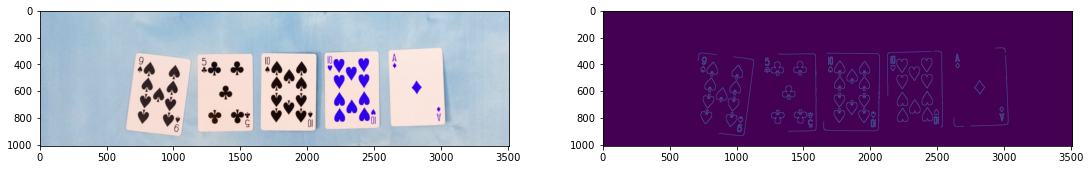

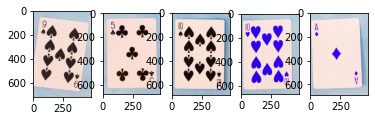

In [11]:
table_segmentation = segment_table("data/train/train_18.jpg")

# Params
bottom_boundary = 2500
T = 500
horizontal_buffer = 50
vertical_buffer = 50

# Cut out buttom of image with supposed T-cards
T_cards = table_segmentation[bottom_boundary:-1,:]

# Attempt to remove some noise
kernel = np.ones((5,5),np.float32)/25
T_cards_filtered = cv2.filter2D(T_cards,-1,kernel)

canny = cv2.Canny(T_cards_filtered, 10, 200)

# Get card boundaries
cards_horizontal_sum = np.sum(canny, axis=0)
left_boundary = np.min(np.where(cards_horizontal_sum > T)) - horizontal_buffer
right_boundary = np.max(np.where(cards_horizontal_sum > T)) + horizontal_buffer
diff = right_boundary - left_boundary
split = int(diff/5)

# Separate cards roughly
cards = []
for i in range(5):
    cur_low = left_boundary + i*split
    cur_high = cur_low + split
    canny_cut = canny[:,cur_low:cur_high]
    canny_vertical_sum = np.sum(canny_cut, axis=1)
    upper_boundary = np.min(np.where(canny_vertical_sum > T)) - vertical_buffer
    lower_boundary = np.max(np.where(canny_vertical_sum > T)) + vertical_buffer
    cards.append(T_cards[upper_boundary:lower_boundary,cur_low:cur_high])
    
# plot
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18.5, 10.5)
ax[0].imshow(T_cards_filtered)
ax[1].imshow(canny)

fig, ax = plt.subplots(1,5)
for i in range(5):
    ax[i].imshow(cards[i])
    
print(np.min(np.where(np.sum(canny,axis=0) > 500)), np.max(np.where(np.sum(canny,axis=0) > 500)))

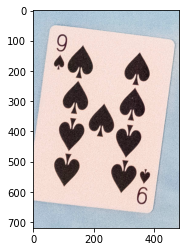

In [58]:
plt.imshow(cards[0])

In [53]:
a = int(np.floor(0.184265*w))
b = int(np.ceil(0.178025*h))
c = int(np.ceil(0.10352*w))
d = int(np.ceil(0.147427*h))

In [60]:
h,w, _ = cards[0].shape
nine = cards[0][b-d//2:b+d//2,a-c//2:a+c//2]
#0.184265 0.178025 0.10352 0.147427

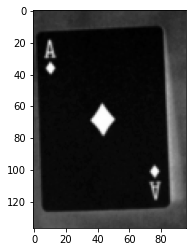

In [96]:
blur = cv2.GaussianBlur(cards[4],(0,0),3)
blur = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
reduction_factor = 5 #30
target_size = (int(blur.shape[1]/reduction_factor),
    int(blur.shape[0]/reduction_factor))
blur = cv2.resize(blur,target_size)
plt.imshow(blur,cmap="Greys")

In [97]:
segmentation = np.zeros(blur.shape,dtype=np.uint8)
for i in iterative_grow(blur,60,10,220):
    segmentation[i[0],i[1]] = 255

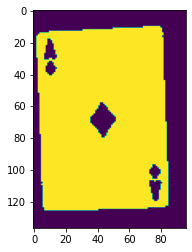

In [98]:
plt.imshow(segmentation)

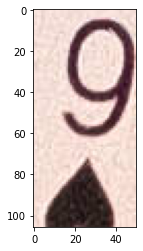

In [64]:
plt.imshow(nine)

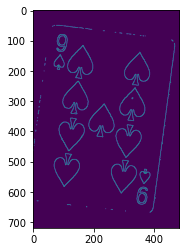

In [13]:
test = cv2.Canny(cards[0],280,350)
plt.imshow(test)